# Model

In [1]:
import json
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import pprint
import itertools
import matplotlib.patches as patches
import pycocotools.mask as mask_util
from typing import List
from sklearn.model_selection import train_test_split
import functools
from fastai2.vision.all import *


dataset_root = Path("../dataset")
annotations_path = dataset_root / "via_region_data_fish_type.json"
pp = pprint.PrettyPrinter(indent=2)

In [2]:
with open(annotations_path) as f:
    annotations_data = list(json.load(f).values())
annotations_data_train, annotations_data_test = train_test_split(annotations_data, test_size=0.25)
len(annotations_data_train), len(annotations_data_test)

(40, 14)

In [3]:
def polygons_to_bitmask(polygons: List[np.ndarray], height: int, width: int) -> np.ndarray:
    assert len(polygons) > 0, "COCOAPI does not support empty polygons"
    rles = mask_util.frPyObjects(polygons, height, width)
    rle = mask_util.merge(rles)
    return mask_util.decode(rle).astype(np.bool)


In [4]:
class FishDataset(object):
    def __init__(self, root, annotations_data, transforms = None):
        self.root = root
        self.annotations_data = list(annotations_data)
        self.transforms = transforms


       
        
    def __getitem__(self, index):
        image, target = self._get(index)
        
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        
        return image, target
        
    @functools.lru_cache(1000)
    def _get(self, index):
        data = self.annotations_data[index]
        file_path = data["filename"]
        image = Image.open(self.root / file_path).convert("RGB")
        
        boxes = []
        polygons = []
        labels = []
        masks = []
        
        for region in data["regions"]:
            shape_attributes = region["shape_attributes"]
            px = shape_attributes["all_points_x"]
            py = shape_attributes["all_points_y"]
            
            poly = [[x, y] for x, y in zip(px, py)]
            poly = [list(itertools.chain.from_iterable(poly))]
            mask = np.uint8(polygons_to_bitmask(poly, image.height, image.width))
            
            box = [min(px), min(py), max(px), max(py)]
            
            category_id = 1 #TODO
            
            boxes.append(box)
            masks.append(mask)
            labels.append(category_id)
           
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id =  torch.tensor([index])
    
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": areas,
            "iscrowd": torch.zeros((len(labels),), dtype=torch.int64)
        }
        
        return image, target
    
    
    def __len__(self):
        return len(self.annotations_data)

In [5]:
def plot_item(image, target):
    image = np.array(image)
    print(image.shape)
    

    ax = plt.axes()
    ax.imshow(image)
    

    for xmin, ymin, xmax, ymax in target["boxes"]:
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
    draw_mask = np.zeros(target["masks"][0].shape)
    for mask in target["masks"]:
        mask = np.array(mask)
        draw_mask += mask
    
    plt.imshow(draw_mask > 0, 'gray', interpolation='none', alpha=.5)

(1086, 1080, 3)


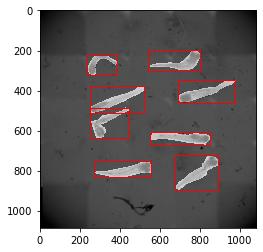

In [6]:
dataset = FishDataset(dataset_root, annotations_data_train)
image, target = dataset[0]
image, target = dataset[35]
plot_item(image, target)

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def create_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels      
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )                               
    return model
    

In [8]:
import detection.transforms as T

def get_transform(train=False):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    
    return T.Compose(transforms)

dataset = FishDataset(dataset_root, annotations_data,  get_transform())

In [9]:
import detection.utils as utils
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=2, 
    shuffle=True, 
    num_workers=4,
    collate_fn=utils.collate_fn
)


In [10]:
num_classes = 2

model = create_model(num_classes)

images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)
output

/home/jordi/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1591914858187/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


{'loss_classifier': tensor(0.7575, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.6769, grad_fn=<DivBackward0>),
 'loss_mask': tensor(3.2745, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_objectness': tensor(0.1947, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.1147, grad_fn=<DivBackward0>)}

In [11]:
def params_splitter(model):
    return [params(model.backbone), params(model.rpn), params(model.roi_heads)]

In [12]:
from detection.engine import train_one_epoch, evaluate

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = FishDataset(dataset_root, annotations_data_train,  get_transform(train=True))
dataset_test = FishDataset(dataset_root, annotations_data_test,  get_transform())

# split the dataset in train and test set
#indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=3, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = create_model(num_classes)
parameter_groups = params_splitter(model)
for o in parameter_groups[0] + parameter_groups[1]:
    o.requires_grad = False

# move model to the right device
model.to(device)

# construct an optimizer
opt_params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005,
#                            momentum=0.9, weight_decay=0.0005)

optimizer = torch.optim.Adam(opt_params, lr=0.00017575106248547893)
# and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                               step_size=3,
#                                               gamma=0.1)



cuda


In [ ]:
# let's train it for 10 epochs
num_epochs = 250

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    #lr_scheduler.step()

    
    if epoch % 1 == 0:
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

        image, target = dataset[1]
        # put the model in evaluation mode
        model.eval()
        t = 0.75
        with torch.no_grad():
        prediction = model([image.to(device)])[0]
        selected = prediction["scores"] > t
        predictcion = {k: torch.squeeze(v[selected].cpu()) for k, v in prediction.items()}


        img = torch.einsum("chw->hwc", image).cpu().detach().numpy()
        plot_item(img, predictcion)
        plt.show()

        image, target = dataset_test[1]
        # put the model in evaluation mode
        model.eval()
        t = 0.75
        with torch.no_grad():
            prediction = model([image.to(device)])[0]
            selected = prediction["scores"] > t
            predictcion = {k: torch.squeeze(v[selected].cpu()) for k, v in prediction.items()}


        img = torch.einsum("chw->hwc", image).cpu().detach().numpy()
        plot_item(img, predictcion)
        plt.show()

print("That's it!")

Epoch: [0]  [ 0/14]  eta: 0:01:57  lr: 0.000014  loss: 0.9387 (0.9387)  loss_classifier: 0.2103 (0.2103)  loss_box_reg: 0.3098 (0.3098)  loss_mask: 0.2627 (0.2627)  loss_objectness: 0.0912 (0.0912)  loss_rpn_box_reg: 0.0647 (0.0647)  time: 8.3815  data: 7.9690  max mem: 6050
Epoch: [0]  [10/14]  eta: 0:00:06  lr: 0.000149  loss: 0.8704 (0.9181)  loss_classifier: 0.1778 (0.1809)  loss_box_reg: 0.2625 (0.2599)  loss_mask: 0.2936 (0.3022)  loss_objectness: 0.0597 (0.1003)  loss_rpn_box_reg: 0.0673 (0.0748)  time: 1.7248  data: 1.3017  max mem: 6050
Epoch: [0]  [13/14]  eta: 0:00:01  lr: 0.000176  loss: 0.8568 (0.9139)  loss_classifier: 0.1778 (0.1835)  loss_box_reg: 0.2475 (0.2574)  loss_mask: 0.2826 (0.3001)  loss_objectness: 0.0597 (0.0957)  loss_rpn_box_reg: 0.0760 (0.0771)  time: 1.8757  data: 1.3769  max mem: 6050
Epoch: [0] Total time: 0:00:26 (1.8828 s / it)
creating index...
index created!
Test:  [0/3]  eta: 0:00:05  model_time: 0.7720 (0.7720)  evaluator_time: 0.5781 (0.5781)  ti

In [ ]:
# pick one image from the test set
image, target = dataset_test[1]
# put the model in evaluation mode
model.eval()
t = 0.9
with torch.no_grad():
    prediction = model([image.to(device)])[0]
    selected = prediction["scores"] > t
    prediction = {k: torch.squeeze(v[selected].cpu()) for k, v in prediction.items()}
    
prediction["scores"]

img = torch.einsum("chw->hwc", image)
plot_item(img, prediction)

In [ ]:
img = torch.einsum("chw->hwc", image)
plot_item(img, target)

In [ ]:
img = torch.einsum("chw->hwc", image)
plot_item(img, prediction)